<a href="https://colab.research.google.com/github/professor91/Crypto-Trading-Strategy/blob/master/CryptoTradingStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Crypto Market Clustering**


The objective of this project is to find out price patterns of crypto currencies and formulate a trading strategy. In order to achieve this objective, we will be using clustering and association analysis techniques to identify any underlying trends and relationships among the various crypto currencies.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# Loading Data

We will be using daily market data of the top 10 crypto currencies from January 2017 to December 2022. The data has been collected from https://in.investing.com/crypto/ and cleaned to remove any inconsistencies and missing values.

The data that we will be collecting from the website includes the following parameters:

- High: The highest price of the crypto currency for the day

- Low: The lowest price of the crypto currency for the day

- Open: The opening price of the crypto currency for the day

- Price (Close): The closing price of the crypto currency for the day

- Volume: The trading volume of the crypto currency for the day

- Change%: The percentage change in the price of the crypto currency from the previous day


In [107]:
import os

path = "/content/drive/MyDrive/DM_project/Datasets_5years/"

files = [file for file in os.listdir(path) if file[-3:] == 'csv']

del files[3]
del files[-2]

files.sort()
files

['BNB Historical Data - Investing.com India.csv',
 'Bitcoin Historical Data - Investing.com India.csv',
 'Cardano Historical Data - Investing.com India.csv',
 'Dogecoin Historical Data - Investing.com India.csv',
 'Ethereum Historical Data - Investing.com India.csv',
 'Polygon Historical Data - Investing.com India.csv',
 'Tether Historical Data - Investing.com India.csv',
 'XRP Historical Data - Investing.com India.csv']

In [108]:
time_period = {
    'start': '2020-01-01',
    'end': '2022-12-31'
}

coins = [file_name.split()[0] for file_name in files]
coins

['BNB',
 'Bitcoin',
 'Cardano',
 'Dogecoin',
 'Ethereum',
 'Polygon',
 'Tether',
 'XRP']

In [109]:
# loading datasets
df = {}

for file_name in files:
  df.update({
      file_name.split()[0]: pd.read_csv(f"{path}{file_name}", index_col='Date', parse_dates=True)
  })

# Pre-Processing


In [110]:
# replace blanks with NaN
for coin in df.keys():
  df[coin].replace('-', np.nan, inplace=True)

## Correct Data Types

The data that we will be collecting from the website includes the following parameters:

- High: float64
- Low: float64
- Open: float64
- Price: float64
- Volume: float64
- Change%: float64


In [111]:
# checking data types
for coin in df.keys():
  print(f'{coin} - {df[coin].info()}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1879 entries, 2022-12-31 to 2017-11-09
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1879 non-null   float64
 1   Open      1879 non-null   float64
 2   High      1879 non-null   float64
 3   Low       1879 non-null   float64
 4   Vol.      1878 non-null   object 
 5   Change %  1879 non-null   object 
dtypes: float64(4), object(2)
memory usage: 102.8+ KB
BNB - None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2191 entries, 2022-12-31 to 2017-01-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     2191 non-null   object
 1   Open      2191 non-null   object
 2   High      2191 non-null   object
 3   Low       2191 non-null   object
 4   Vol.      2191 non-null   object
 5   Change %  2191 non-null   object
dtypes: object(6)
memory usage: 119.8+ KB
Bitcoin - None
<class 'pandas

In [112]:
# change data types
for coin in df.keys():
  df[coin]['Vol.'] = df[coin]['Vol.'].str.replace('.','').str.replace('M','000000').str.replace('K','000').str.replace('B', '000000000').astype(float)
  df[coin]['Change %'] = df[coin]['Change %'].str.replace('%','').str.replace(',','').astype(float)

for coin in ['Bitcoin', 'Ethereum']:
  df[coin]['Price'] = df[coin]['Price'].str.replace(',','').astype(float)
  df[coin]['Open'] = df[coin]['Open'].str.replace(',','').astype(float)
  df[coin]['High'] = df[coin]['High'].str.replace(',','').astype(float)
  df[coin]['Low'] = df[coin]['Low'].str.replace(',','').astype(float)

<ipython-input-112-3388059f735e>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



## Missing Values

We have used Linear Interpolation to fill the missing values in the dataset. Linear interpolation, in the context of time series analysis, is a method for filling missing values by estimating the values that lie between two known values.

In [113]:
# count missing values
pd.DataFrame([df[coin].isna().sum() for coin in coins], index=coins)

,Price,Open,High,Low,Vol.,Change %
BNB,0,0,0,0,1,0
Bitcoin,0,0,0,0,0,0
Cardano,0,0,0,0,5,0
Dogecoin,0,0,0,0,1,0
Ethereum,0,0,0,0,1,0
Polygon,0,0,0,0,0,0
Tether,0,0,0,0,0,0
XRP,0,0,0,0,12,0


In [114]:
# Fill missing values with the mean of the previous two and next two values
for coin in df.keys():
  df[coin]['Vol.'].fillna(df[coin]['Vol.'].rolling(window=5, min_periods=1, center=True).mean(), inplace=True)

## Drop records not required

Starting date and Ending date has been defined at the beginning of the notebook. Since crypto currencies launched at different times, we picked the time frame shared by all for the analysis

In [115]:
# Reset the range for all remaining datasets
for coin in df.keys():
    df[coin] = df[coin].loc[time_period['start']:time_period['end']]

In [116]:
pd.DataFrame([[df[coin].shape[0] for coin in coins]], columns=coins)

,BNB,Bitcoin,Cardano,Dogecoin,Ethereum,Polygon,Tether,XRP
0,1096,1096,1096,1096,1096,1096,1096,1096


In [117]:
for coin_df in df.values():
  coin_df.sort_index(inplace=True)

## Combine into single dataset

Until now we had a dictionary which contained all the datasets as values and their respective keys as the name of the currencies. For analysis we have to combine all the datasets into one.

We have also Multi-indexed the dataset.

In [118]:
# Create a new dataset for Price of each currency
df_price = pd.DataFrame(index=df['Bitcoin'].index, columns=df.keys())
for coin in df.keys():
    df_price[coin] = df[coin]['Price']
    
# Create a new dataset for Price of each currency
df_open = pd.DataFrame(index=df['Bitcoin'].index, columns=df.keys())
for coin in df.keys():
    df_open[coin] = df[coin]['Open']

# Create a new dataset for Price of each currency
df_high = pd.DataFrame(index=df['Bitcoin'].index, columns=df.keys())
for coin in df.keys():
    df_high[coin] = df[coin]['High']

# Create a new dataset for Price of each currency
df_low = pd.DataFrame(index=df['Bitcoin'].index, columns=df.keys())
for coin in df.keys():
    df_low[coin] = df[coin]['Low']

# Create a new dataset for Vol. of each currency
df_vol = pd.DataFrame(index=df['Bitcoin'].index, columns=df.keys())
for coin in df.keys():
    df_vol[coin] = df[coin]['Vol.']

# Create a new dataset for Vol. of each currency
df_change = pd.DataFrame(index=df['Bitcoin'].index, columns=df.keys())
for coin in df.keys():
    df_change[coin] = df[coin]['Change %']

merged_df = pd.concat([df_price, df_open, df_high, df_low, df_vol, df_change], axis=1, join='outer', keys=['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'])
merged_df.head()

Price                                                              \
              BNB Bitcoin Cardano  Dogecoin Ethereum Polygon  Tether      XRP   
Date                                                                            
2020-01-01  13.70  7199.8  0.0335  0.002040   130.75   0.015  1.0121  0.19307   
2020-01-02  13.03  6967.0  0.0327  0.001999   127.19   0.015  1.0053  0.18748   
2020-01-03  13.65  7343.1  0.0341  0.002042   134.27   0.015  1.0039  0.19321   
2020-01-04  13.85  7376.8  0.0344  0.002307   134.33   0.015  1.0050  0.19311   
2020-01-05  14.07  7372.5  0.0346  0.002080   135.59   0.015  1.0032  0.19455   

             Open          ...         Vol.               Change %          \
              BNB Bitcoin  ...       Tether           XRP      BNB Bitcoin   
Date                       ...                                               
2020-01-01  13.73  7196.4  ...  108000000.0  1.230000e+11    -0.25    0.05   
2020-01-02  13.70  7199.7  ...  279000000.0  1.470000e+11    -4.85   -3.23   
2020-01-03  13.02  6967.1  ...  623000000.0  1.740000e+11     4.72    5.40   
2020-01-04  13.65  7345.1  ...  274000000.0  1.110000e+11     1.49    0.46   
2020-01-05  13.85  7376.8  ...  461000000.0  1.150000e+11     1.58   -0.06   

                                                           
           Cardano Dogecoin Ethereum Polygon Tether   XRP  
Date                                                       
2020-01-01    1.94     1.24     1.19    8.45   0.73  0.07  
2020-01-02   -2.33    -1.98    -2.72    0.00  -0.68 -2.89  
2020-01-03    4.32     2.14     5.56    0.00  -0.14  3.06  
2020-01-04    0.79    12.99     0.04    0.00   0.11 -0.05  
2020-01-05    0.73    -9.86     0.94    0.00  -0.18  0.74  

[5 rows x 48 columns]

In [119]:
merged_df.columns.levels

FrozenList([['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], ['BNB', 'Bitcoin', 'Cardano', 'Dogecoin', 'Ethereum', 'Polygon', 'Tether', 'XRP']])

# Trading Strategy

In [120]:
ma = pd.DataFrame()
rsi = pd.DataFrame()

##Moving Average

In [121]:
# Calculate n-day Moving Average
ma_n = 200
for coin in coins:
  ma[coin] = merged_df['Price'][coin].rolling(window=ma_n).mean()
ma['Bitcoin'].iloc[ma_n-1:]

Date
2020-07-18     8527.2010
2020-07-19     8537.2420
2020-07-20     8548.2190
2020-07-21     8558.4400
2020-07-22     8569.1245
                 ...    
2022-12-27    19898.7470
2022-12-28    19839.4610
2022-12-29    19789.6115
2022-12-30    19760.4075
2022-12-31    19732.3080
Name: Bitcoin, Length: 897, dtype: float64

##RSI

In [122]:
for coin in coins:
  # Calculate RSI
  delta = merged_df['Price'][coin].diff()
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)
  avg_gain = gain.rolling(window=14).mean()
  avg_loss = loss.rolling(window=14).mean()
  rs = avg_gain / avg_loss
  rsi[coin] = 100 - (100 / (1 + rs))

rsi['Bitcoin'].iloc[ma_n-1:]
# rsi

Date
2020-07-18    51.554899
2020-07-19    55.591758
2020-07-20    40.435442
2020-07-21    56.163740
2020-07-22    54.117531
                ...    
2022-12-27    29.492524
2022-12-28    27.326804
2022-12-29    35.049233
2022-12-30    49.344876
2022-12-31    42.655800
Name: Bitcoin, Length: 897, dtype: float64

##Signal

In [123]:
signal = pd.DataFrame(index=ma.index[ma_n-1:])

def trading_signal():
  for coin in coins:
    signal[coin] = np.where(
                            (rsi[coin].iloc[ma_n-1:] < 30) & (merged_df['Price'][coin].iloc[ma_n-1:] > ma[coin].iloc[ma_n-1:]), 
                            'buy', 
                            np.nan
                            )
    signal[coin] = np.where(
                            (rsi[coin].iloc[ma_n-1:] > 70) & (merged_df['Price'][coin].iloc[ma_n-1:] < ma[coin].iloc[ma_n-1:]), 
                            'sell', 
                            signal[coin]
                            )

trading_signal()
signal

,BNB,Bitcoin,Cardano,Dogecoin,Ethereum,Polygon,Tether,XRP
Date,,,,,,,,
2020-07-18,nan,nan,nan,nan,nan,nan,nan,nan
2020-07-19,nan,nan,nan,nan,nan,nan,nan,nan
2020-07-20,nan,nan,nan,nan,nan,nan,nan,nan
2020-07-21,nan,nan,nan,nan,nan,nan,nan,nan
2020-07-22,nan,nan,nan,buy,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...
2022-12-27,nan,nan,nan,buy,nan,buy,nan,nan
2022-12-28,nan,nan,nan,nan,nan,nan,nan,nan
2022-12-29,nan,nan,nan,nan,nan,nan,nan,nan


In [124]:
print('Frequency of buy signals')
pd.DataFrame([[signal[coin].value_counts()["buy"] for coin in coins]], columns=coins, index=['buy'])

Frequency of buy signals


,BNB,Bitcoin,Cardano,Dogecoin,Ethereum,Polygon,Tether,XRP
buy,16,18,23,56,11,40,1,10


In [125]:
print('Frequency of sell signals')
pd.DataFrame([[signal[coin].value_counts()["sell"] for coin in coins]], columns=coins, index=['sell'])

Frequency of sell signals


,BNB,Bitcoin,Cardano,Dogecoin,Ethereum,Polygon,Tether,XRP
sell,30,38,19,18,39,15,4,24


In [126]:
print("Dates of buy signals")
signal[signal[coin].isin(['buy'])].index

Dates of buy signals


DatetimeIndex(['2020-09-15', '2020-12-14', '2021-02-26', '2021-02-27',
               '2021-02-28', '2021-06-17', '2021-11-22', '2021-11-23',
               '2021-11-25', '2022-10-23'],
              dtype='datetime64[ns]', name='Date', freq=None)

# EDA

In [127]:
compare = ['Bitcoin', 'Ethereum', 'Tether']

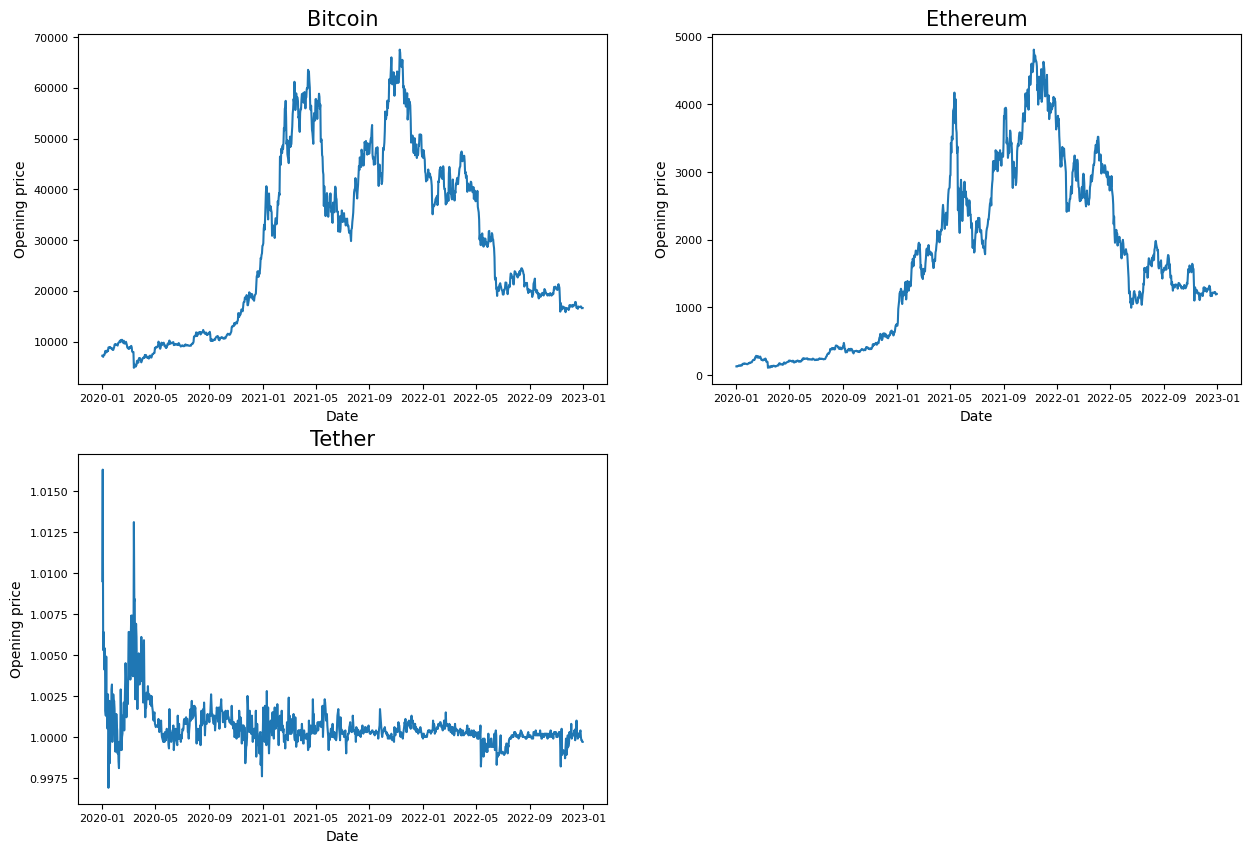

In [128]:
plt.figure(figsize = (15,10)) 

plt.subplot(2,2,1) 
plt.title(compare[0],fontsize = 15)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Date',fontsize = 10)
plt.ylabel('Opening price',fontsize = 10)
plt.plot(merged_df['Open'][compare[0]])

plt.subplot(2,2,2)
plt.title(compare[1],fontsize = 15)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Date',fontsize = 10)
plt.ylabel('Opening price',fontsize = 10)
plt.plot(merged_df['Open'][compare[1]])

plt.subplot(2,2,3)
plt.title(compare[2],fontsize = 15)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Date',fontsize = 10)
plt.ylabel('Opening price',fontsize = 10)
plt.plot(merged_df['Open'][compare[2]])

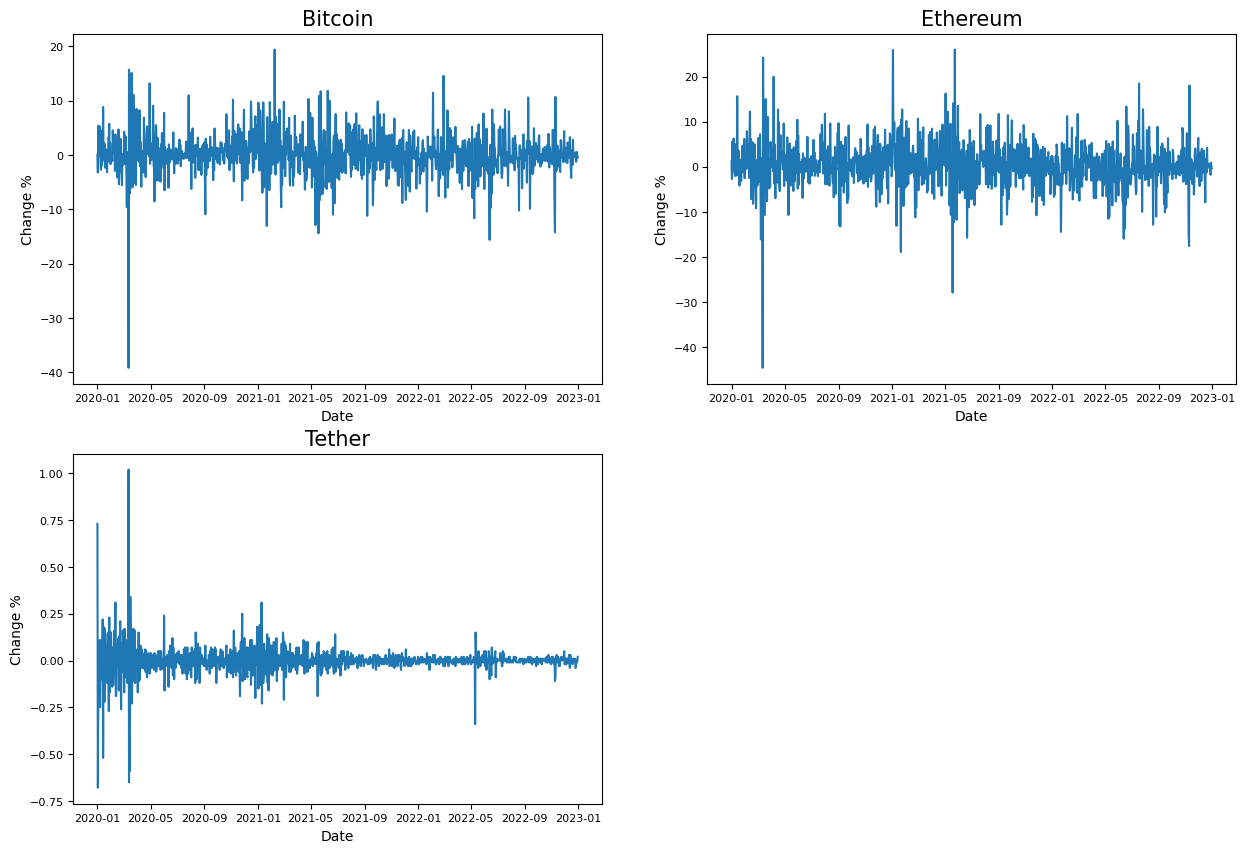

In [129]:
plt.figure(figsize = (15,10)) 

plt.subplot(2,2,1) 
plt.title(compare[0],fontsize = 15)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Date',fontsize = 10)
plt.ylabel('Change %',fontsize = 10)
plt.plot(merged_df['Change %'][compare[0]])

plt.subplot(2,2,2)
plt.title(compare[1],fontsize = 15)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Date',fontsize = 10)
plt.ylabel('Change %',fontsize = 10)
plt.plot(merged_df['Change %'][compare[1]])

plt.subplot(2,2,3)
plt.title(compare[2],fontsize = 15)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Date',fontsize = 10)
plt.ylabel('Change %',fontsize = 10)
plt.plot(merged_df['Change %'][compare[2]])

In [130]:
change = np.array(merged_df['Change %']).T

Frequency of positive, negative and neutral changes in movements (based on Change % attribute)


<Axes: >

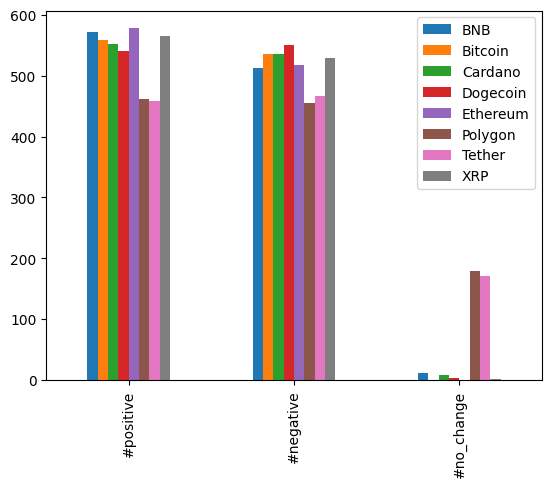

In [131]:
print('Frequency of positive, negative and neutral changes in movements (based on Change % attribute)')
pd.DataFrame(
    [
      [np.sum(change[i]>0) for i in range(len(change))],
      [np.sum(change[i]<0) for i in range(len(change))],
      [np.sum(change[i]==0) for i in range(len(change))]
    ], 
    columns=coins, index=['#positive', '#negative', '#no_change']
).plot(kind='bar')

In [132]:
# plt.figure(figsize = (10,5))
# plt.title(compare[0],fontsize = 15)
# plt.xticks(fontsize = 8)
# plt.yticks(fontsize = 8)
# plt.xlabel('Date',fontsize = 10)
# plt.ylabel('Price',fontsize = 10)
# plt.plot(merged_df.iloc[0:30]['Open'][compare[0]],label = 'Open') # Opening prices of first 30 days are plotted against date
# plt.plot(merged_df.iloc[0:30]['Price'][compare[0]],label = 'Close') # Closing prices of first 30 days are plotted against date
# plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 10}) # Properties of legend box

# Features

In [133]:
crypto_open = np.array(merged_df['Open']).T
crypto_close = np.array(merged_df['Price']).T

In [134]:
movements = crypto_close-crypto_open
movements

array([[-3.000e-02, -6.700e-01,  6.300e-01, ...,  1.900e+00, -5.000e-01,
         3.000e-01],
       [ 3.400e+00, -2.327e+02,  3.760e+02, ...,  9.020e+01, -2.920e+01,
        -6.980e+01],
       [ 7.000e-04, -8.000e-04,  1.400e-03, ..., -4.300e-03,  1.800e-03,
        -1.000e-04],
       ...,
       [ 1.000e-03,  0.000e+00,  0.000e+00, ..., -6.000e-03, -1.600e-02,
        -3.000e-03],
       [ 2.600e-03, -1.100e-02, -1.400e-03, ..., -1.000e-04,  0.000e+00,
         2.000e-04],
       [ 1.400e-04, -5.580e-03,  5.720e-03, ..., -1.384e-02,  3.090e-03,
        -6.440e-03]])

Frequency of positive, negative and neutral changes in movements 
(based on calculated difference in Opening and Closing price)


<Axes: >

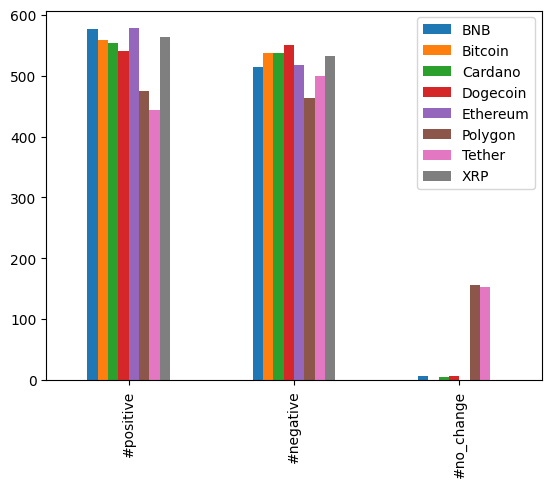

In [135]:
print('Frequency of positive, negative and neutral changes in movements \n(based on calculated difference in Opening and Closing price)')
pd.DataFrame(
    [
      [np.sum(movements[i]>0) for i in range(len(movements))],
      [np.sum(movements[i]<0) for i in range(len(movements))],
      [np.sum(movements[i]==0) for i in range(len(movements))]
    ], 
    columns=coins, index=['#positive', '#negative', '#no_change']
).plot(kind='bar')

In [136]:
sum_of_movements = np.sum(movements,1)
pd.DataFrame([sum_of_movements], columns=coins, index=['Sum'])

,BNB,Bitcoin,Cardano,Dogecoin,Ethereum,Polygon,Tether,XRP
Sum,230.21,8919.1,0.2761,0.063618,1012.95,0.701,-0.0777,0.13509


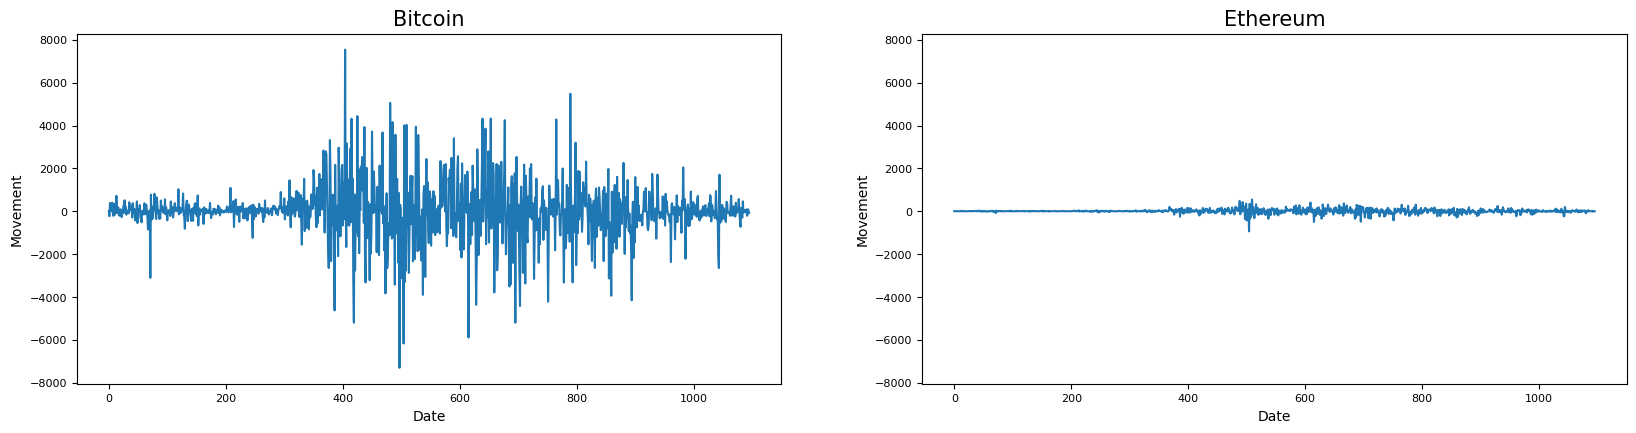

In [137]:
compare = ['Bitcoin', 'Ethereum']

plt.figure(figsize = (20,10)) 

ax1 = plt.subplot(2,2,1)
plt.title(compare[0],fontsize = 15)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Date',fontsize = 10)
plt.ylabel('Movement',fontsize = 10)
plt.plot(movements[coins.index(compare[0])])

ax2= plt.subplot(2,2,2,sharey = ax1)
plt.title(compare[1],fontsize = 15)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Date',fontsize = 10)
plt.ylabel('Movement',fontsize = 10)
plt.plot(movements[coins.index(compare[1])])

## Normalize

In [138]:
print('Min Max Values of movements')
pd.DataFrame(movements.T, columns=coins).describe().loc[['min', 'max']]

Min Max Values of movements


,BNB,Bitcoin,Cardano,Dogecoin,Ethereum,Polygon,Tether,XRP
min,-173.15,-7310.3,-0.5338,-0.145905,-940.53,-0.827,-0.0110,-0.52885
max,137.00,7542.1,0.4164,0.182923,545.49,0.723,0.0102,0.35522


In [139]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer() # Define a Normalizer

norm_movements = normalizer.fit_transform(movements) # Fit and transform

Min Max Values of normalized movements


<Axes: >

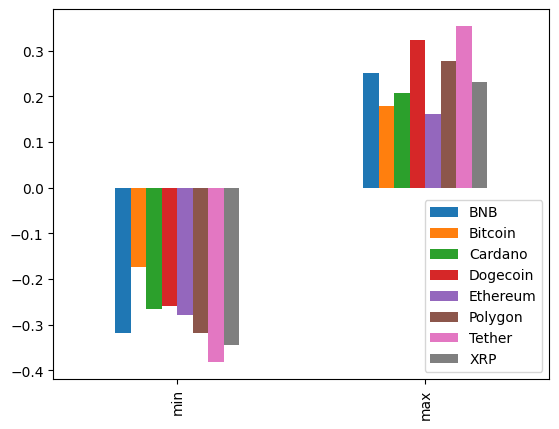

In [140]:
print('Min Max Values of normalized movements')
pd.DataFrame(norm_movements.T, columns=coins).describe().loc[['min', 'max']].plot(kind='bar')

Sum of normalized Change % attribute


<Axes: >

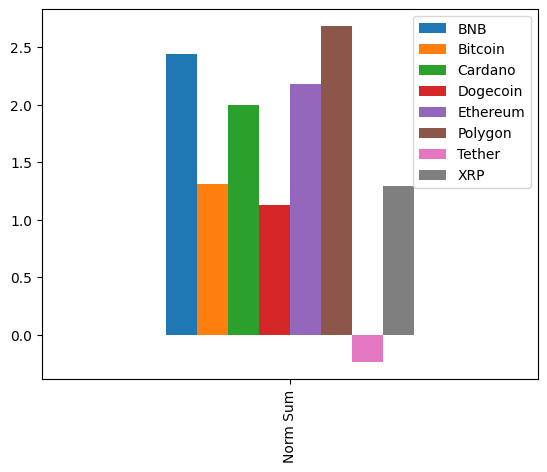

In [141]:
print('Sum of normalized Change % attribute')
pd.DataFrame([np.sum(normalizer.fit_transform(change),1)], columns=coins, index=['Norm Sum']).plot(kind='bar')

Sum of normalized movements


<Axes: >

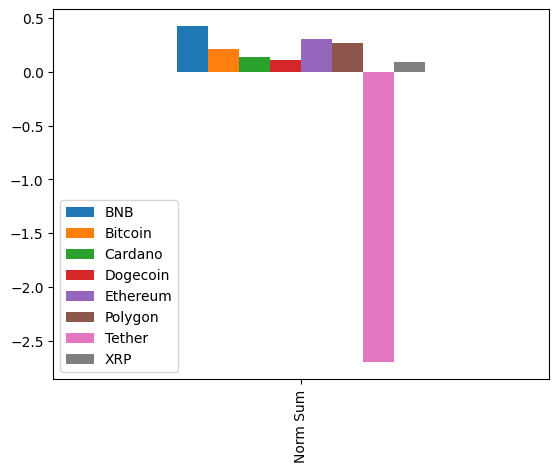

In [142]:
print('Sum of normalized movements')
sum_of_norm_movements = np.sum(norm_movements,1)
pd.DataFrame([sum_of_norm_movements], columns=coins, index=['Norm Sum']).plot(kind='bar')

In [143]:
print('Plot of normalized movements of each coin')
for i, coin in enumerate(coins):
  fig= px.line(pd.DataFrame(norm_movements[i], columns=[coin]))
  fig.show()

Plot of normalized movements of each coin


# Clustering

In [144]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

##K-means

In [145]:
# Import the necessary packages
from sklearn.cluster import KMeans

# Define a normalizer
normalizer = Normalizer()

# Create Kmeans model
kmeans = KMeans(n_clusters=5,max_iter = 10000)

# Make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)

# Fit pipeline to daily stock movements
pipeline.fit(norm_movements)
k_predictions = pipeline.predict(norm_movements)
k_predictions

df_k = pd.DataFrame({'cluster':k_predictions, 'coins':df.keys()})
df_k

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,cluster,coins
0,1,BNB
1,1,Bitcoin
2,4,Cardano
3,3,Dogecoin
4,1,Ethereum
5,0,Polygon
6,2,Tether
7,4,XRP


##DBSCAN

In [146]:
# Import the necessary packages
from sklearn.cluster import DBSCAN

# Define a normalizer
normalizer = Normalizer()

# Create DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=3)

# Make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)

pipeline.fit(norm_movements)
d_predictions = pipeline.predict(norm_movements)
d_predictions

df_d = pd.DataFrame({'cluster':d_predictions, 'coins':df.keys()})
df_d

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,cluster,coins
0,2,BNB
1,2,Bitcoin
2,3,Cardano
3,4,Dogecoin
4,2,Ethereum
5,0,Polygon
6,1,Tether
7,3,XRP


##Hierarchical Clustering

In [147]:
# Import the necessary packages
from sklearn.cluster import AgglomerativeClustering

# Define a normalizer
normalizer = Normalizer()

# Create Hierarchical Clustering model
agg_clustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')

# Make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)


pipeline.fit(norm_movements)
h_predictions = pipeline.predict(norm_movements)
h_predictions

df_h = pd.DataFrame({'cluster':h_predictions, 'coins':df.keys()})
df_h

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,cluster,coins
0,1,BNB
1,1,Bitcoin
2,0,Cardano
3,2,Dogecoin
4,1,Ethereum
5,4,Polygon
6,3,Tether
7,0,XRP


#Backtesting

In [148]:
basket = {cluster: list(df_k.loc[df_k['cluster'] == cluster, 'coins']) for cluster in set(df_k['cluster'])}
basket

{0: ['Polygon'],
 1: ['BNB', 'Bitcoin', 'Ethereum'],
 2: ['Tether'],
 3: ['Dogecoin'],
 4: ['Cardano', 'XRP']}

In [149]:
import random

def backtest(trade_in):
    print(trade_in)
    
    coins = trade_in
    amount = 1000
    position_size = amount / 5
    unit = {}
    
    for coin in coins:
      unit[coin] = 0
    
    for date in signal.index:
      sig = {}
      open = {}
      close = {}
      for coin in coins:
        sig[coin] = signal[coin][date]
        open[coin] = merged_df['Open'][coin].loc[date]
        close[coin] = merged_df['Price'][coin].loc[date]
        
        if sig[coin] == 'buy' and amount-position_size > 0:
          bought = position_size/open[coin]
          unit[coin] += position_size/open[coin]
          amount -= position_size
          print(f'date: {date}, signal: {sig[coin]}, coin: {coin}, open: {open[coin]}, total_unit: {unit}, invested_amount: {position_size}, remaining_amount: {amount}')
        
        if sig[coin] == 'sell' and unit[coin] > 0:
          sold = unit[coin] * close[coin]
          amount += unit[coin] * close[coin]
          unit[coin] = 0
          print(f'date: {date}, signal: {sig[coin]}, coin: {coin}, close: {close[coin]}, total_unit: {unit}, profit: {sold}, remaining_amount: {amount}')

    for coin in unit.keys():
      if unit[coin] != 0:
        unit[coin]
    
    return int(amount)

trading_in = [random.choice(basket[key]) for key in basket]
# trading_in = ['Ethereum']
backtest(trading_in)

['Polygon', 'BNB', 'Tether', 'Dogecoin', 'Cardano']
date: 2020-07-22 00:00:00, signal: buy, coin: Dogecoin, open: 0.0033, total_unit: {'Polygon': 0, 'BNB': 0, 'Tether': 0, 'Dogecoin': 60606.06060606061, 'Cardano': 0}, invested_amount: 200.0, remaining_amount: 800.0
date: 2020-07-27 00:00:00, signal: buy, coin: Polygon, open: 0.021, total_unit: {'Polygon': 9523.809523809523, 'BNB': 0, 'Tether': 0, 'Dogecoin': 60606.06060606061, 'Cardano': 0}, invested_amount: 200.0, remaining_amount: 600.0
date: 2020-07-28 00:00:00, signal: buy, coin: Polygon, open: 0.021, total_unit: {'Polygon': 19047.619047619046, 'BNB': 0, 'Tether': 0, 'Dogecoin': 60606.06060606061, 'Cardano': 0}, invested_amount: 200.0, remaining_amount: 400.0
date: 2020-07-29 00:00:00, signal: buy, coin: Polygon, open: 0.02, total_unit: {'Polygon': 29047.619047619046, 'BNB': 0, 'Tether': 0, 'Dogecoin': 60606.06060606061, 'Cardano': 0}, invested_amount: 200.0, remaining_amount: 200.0
date: 2020-11-21 00:00:00, signal: sell, coin: Po

29725

#Validation

##Association

In [ ]:
!pip install efficient-apriori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_change.head()

,Ethereum,Tether,BNB,XRP,Cardano,Dogecoin,Polygon,Bitcoin
Date,,,,,,,,
2020-01-01,1.19,0.73,-0.25,0.07,1.94,1.24,8.45,0.05
2020-01-02,-2.72,-0.68,-4.85,-2.89,-2.33,-1.98,0.00,-3.23
2020-01-03,5.56,-0.14,4.72,3.06,4.32,2.14,0.00,5.40
2020-01-04,0.04,0.11,1.49,-0.05,0.79,12.99,0.00,0.46
2020-01-05,0.94,-0.18,1.58,0.74,0.73,-9.86,0.00,-0.06


In [ ]:
records = []
for i in df_change.index:
  transaction = []

  for coin in df_change.columns:
    if df_change.loc[i, coin] > 0:
      transaction.append(coin)

  records.append(transaction)

In [ ]:
from efficient_apriori import apriori

itemsets, rules = apriori(records, min_support=0.3, min_confidence=0.90)

print(f"Itemsets: {len(itemsets)}, Rules: {len(rules)}")

Itemsets: 5, Rules: 44


In [ ]:
conf = {}
for coin in coins:
    conf[coin] = {coin: 0 for coin in coins}
for rule in rules:
  for i in range(len(rule.lhs)):
    for j in range(len(rule.rhs)):
      conf[rule.lhs[i]][rule.rhs[j]] += 1


conf = {key: {inner_key: inner_value for inner_key, inner_value in value.items() if inner_value != 0} for key, value in conf.items()}



{0: ['Bitcoin', 'Ethereum', 'XRP', 'BNB', 'Cardano', 'Polygon'],
 1: ['Tether'],
 2: ['Dogecoin']}

{0: ['Tether'],
 1: ['Bitcoin', 'Ethereum', 'BNB', 'Polygon'],
 2: ['Dogecoin'],
 3: ['XRP', 'Cardano']}

{0: ['XRP', 'Cardano'],
 1: ['Tether'],
 2: ['Dogecoin'],
 3: ['Bitcoin', 'Ethereum', 'BNB'],
 4: ['Polygon']}

conf

{'Ethereum': {'BNB': 4, 'XRP': 2, 'Cardano': 4, 'Bitcoin': 8},
 'Tether': {},
 'BNB': {'Ethereum': 11, 'XRP': 1, 'Cardano': 3, 'Bitcoin': 5},
 'XRP': {'Ethereum': 10, 'BNB': 1, 'Cardano': 4, 'Bitcoin': 6},
 'Cardano': {'Ethereum': 10, 'BNB': 3, 'XRP': 2, 'Bitcoin': 6},
 'Dogecoin': {'Ethereum': 7, 'BNB': 2, 'XRP': 3, 'Cardano': 4, 'Bitcoin': 5},
 'Polygon': {'Ethereum': 4},
 'Bitcoin': {'Ethereum': 12, 'BNB': 3, 'XRP': 1, 'Cardano': 4}}

###Association Validation Reasoning

`conf` dictionary shows how many times a currency impacted other currencies.

- **Tether** and **Polygon** neither impacted other currencies nor got impacted by other currencies, therefore they are clustered with none.

- **Doge** affected prices of other currencies but no other currency impacted it, therefore it is also clustered with none.

- **Bitcoin**, **Ethereum**, **Cardano**, **BNB** and **XRP** impact each other, hence they are clustered together when we made only 3 clusters.

- As we increased number of clusters **XRP** and **Cardano** got clustered separatly, since **Cardano** impacts **XRP** highest among the other 3.


##Correlation

In [ ]:
import seaborn as sns

{0: ['Bitcoin', 'Ethereum', 'XRP', 'BNB', 'Cardano', 'Polygon'],
 1: ['Tether'],
 2: ['Dogecoin']}

{0: ['Tether'],
 1: ['Bitcoin', 'Ethereum', 'BNB', 'Polygon'],
 2: ['Dogecoin'],
 3: ['XRP', 'Cardano']}

{0: ['XRP', 'Cardano'],
 1: ['Tether'],
 2: ['Dogecoin'],
 3: ['Bitcoin', 'Ethereum', 'BNB'],
 4: ['Polygon']}

df_change.corr()
# sns.heatmap(df_change.corr())

,Ethereum,Tether,BNB,XRP,Cardano,Dogecoin,Polygon,Bitcoin
Ethereum,1.000000,-0.164823,0.695259,0.619851,0.724916,0.020748,0.657947,0.825945
Tether,-0.164823,1.000000,-0.141563,-0.118209,-0.113701,0.064461,-0.084193,-0.185040
BNB,0.695259,-0.141563,1.000000,0.543573,0.615189,0.043501,0.627949,0.680341
XRP,0.619851,-0.118209,0.543573,1.000000,0.575599,0.013285,0.516430,0.588834
Cardano,0.724916,-0.113701,0.615189,0.575599,1.000000,0.032411,0.621732,0.672112
Dogecoin,0.020748,0.064461,0.043501,0.013285,0.032411,1.000000,0.026995,0.021627
Polygon,0.657947,-0.084193,0.627949,0.516430,0.621732,0.026995,1.000000,0.599914
Bitcoin,0.825945,-0.185040,0.680341,0.588834,0.672112,0.021627,0.599914,1.000000


###Correlation Validation Reasoning

- **Tether**, **Doge** are lest correlated to any other currency so they, therefore they are clustered with none.

- **Bitcoin** is highly correlated with **Ethereum**, **BNB**, therefore they are clustered together


- **XRP** is less correlated with **Ethereum**, **Bitcoin**, **BNB** hence not in their cluster.

- **Polygon** is relatively less correlated with other currencies so given the chance it was clustered separately in n=5 clustering.

#End

